# Cleaning not-null values

After dealing with many datasets I can tell you that "missing data" is not such a big deal. The best thing that can happen is to clearly see values like `np.nan`. The only thing you need to do is just use methods like `isnull` and `fillna`/`dropna` and pandas will take care of the rest.

But sometimes, you can have invalid values that are not just "missing data" (`None`, or `nan`). For example:

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.DataFrame({
    'Sex': ['M', 'F', 'F', 'D', '?'],
    'Age': [29, 30, 24, 290, 25],
})
df

,Sex,Age
0,M,29
1,F,30
2,F,24
3,D,290
4,?,25


The previous `DataFrame` doesn't have any "missing value", but clearly has invalid data. `290` doesn't seem like a valid age, and `D` and `?` don't correspond with any known sex category. How can you clean these not-missing, but clearly invalid values then?

### Finding Unique Values

The first step to clean invalid values is to **notice** them, then **identify** them and finally handle them appropriately (remove them, replace them, etc). Usually, for a "categorical" type of field (like Sex, which only takes values of a discrete set `('M', 'F')`), we start by analyzing the variety of values present. For that, we use the `unique()` method:

In [ ]:
df['Sex'].unique()

array(['M', 'F', 'D', '?'], dtype=object)

In [ ]:
df['Sex'].value_counts()

F    2
D    1
?    1
M    1
Name: Sex, dtype: int64

Clearly if you see values like `'D'` or `'?'`, it'll immediately raise your attention. Now, what to do with them? Let's say you picked up the phone, called the survey company and they told you that `'D'` was a typo and it should actually be `F`. You can use the `replace` function to replace these values:

In [ ]:
df['Sex'].replace('D', 'F')

0    M
1    F
2    F
3    F
4    ?
Name: Sex, dtype: object

It can accept a dictionary of values to replace. For example, they also told you that there might be a few `'N's`, that should actually be `'M's`:

In [ ]:
df['Sex'].replace({'D': 'F', 'N': 'M'})

0    M
1    F
2    F
3    F
4    ?
Name: Sex, dtype: object

If you have many columns to replace, you could apply it at "DataFrame level":

In [ ]:
df.replace({
    'Sex': {
        'D': 'F',
        'N': 'M'
    },
    'Age': {
        290: 29
    }
})

,Sex,Age
0,M,29
1,F,30
2,F,24
3,F,29
4,?,25


In the previous example, I explicitly replaced 290 with 29 (assuming it was just an extra 0 entered at data-entry phase). But what if you'd like to remove all the extra 0s from the ages columns? (example, `150 > 15`, `490 > 49`).

The first step would be to just set the limit of the "not possible" age. Is it 100? 120? Let's say that anything above 100 isn't credible for **our** dataset. We can then combine boolean selection with the operation:

In [ ]:
df[df['Age'] > 100]

,Sex,Age
3,D,290


And we can now just divide by 10:

In [ ]:
df.loc[df['Age'] > 100, 'Age'] = df.loc[df['Age'] > 100, 'Age'] / 10

In [ ]:
df

,Sex,Age
0,M,29.0
1,F,30.0
2,F,24.0
3,D,29.0
4,?,25.0


![separator1](https://i.imgur.com/ZUWYTii.png)

### Duplicates

Checking duplicate values is extremely simple. It'll behave differently between Series and DataFrames. Let's start with Series. As an example, let's say we're throwing a fancy party and we're inviting Ambassadors from Europe. But can only invite one ambassador per country. This is our original list, and as you can see, both the UK and Germany have duplicated ambassadors:

In [ ]:
ambassadors = pd.Series([
    'France',
    'United Kingdom',
    'United Kingdom',
    'Italy',
    'Germany',
    'Germany',
    'Germany',
], index=[
    'Gérard Araud',
    'Kim Darroch',
    'Peter Westmacott',
    'Armando Varricchio',
    'Peter Wittig',
    'Peter Ammon',
    'Klaus Scharioth '
])

In [ ]:
ambassadors

Gérard Araud                  France
Kim Darroch           United Kingdom
Peter Westmacott      United Kingdom
Armando Varricchio             Italy
Peter Wittig                 Germany
Peter Ammon                  Germany
Klaus Scharioth              Germany
dtype: object

The two most important methods to deal with duplicates are `duplicated` (that will tell you which values are duplicates) and `drop_duplicates` (which will just get rid of duplicates):

In [ ]:
ambassadors.duplicated()

Gérard Araud          False
Kim Darroch           False
Peter Westmacott       True
Armando Varricchio    False
Peter Wittig          False
Peter Ammon            True
Klaus Scharioth        True
dtype: bool

In this case `duplicated` didn't consider `'Kim Darroch'`, the first instance of the United Kingdom or `'Peter Wittig'` as duplicates. That's because, by default, it'll consider the first occurrence of the value as not-duplicate. You can change this behavior with the `keep` parameter:

In [ ]:
ambassadors.duplicated(keep='last')

Gérard Araud          False
Kim Darroch            True
Peter Westmacott      False
Armando Varricchio    False
Peter Wittig           True
Peter Ammon            True
Klaus Scharioth       False
dtype: bool

In this case, the result is "flipped", `'Kim Darroch'` and `'Peter Wittig'` (the first ambassadors of their countries) are considered duplicates, but `'Peter Westmacott'` and `'Klaus Scharioth'` are not duplicates. You can also choose to mark all of them as duplicates with `keep=False`:

In [ ]:
ambassadors.duplicated(keep=False)

Gérard Araud          False
Kim Darroch            True
Peter Westmacott       True
Armando Varricchio    False
Peter Wittig           True
Peter Ammon            True
Klaus Scharioth        True
dtype: bool

A similar method is `drop_duplicates`, which just excludes the duplicated values and also accepts the `keep` parameter:

In [ ]:
ambassadors.drop_duplicates()

Gérard Araud                  France
Kim Darroch           United Kingdom
Armando Varricchio             Italy
Peter Wittig                 Germany
dtype: object

In [ ]:
ambassadors.drop_duplicates(keep='last')

Gérard Araud                  France
Peter Westmacott      United Kingdom
Armando Varricchio             Italy
Klaus Scharioth              Germany
dtype: object

In [ ]:
ambassadors.drop_duplicates(keep=False)

Gérard Araud          France
Armando Varricchio     Italy
dtype: object

### Duplicates in DataFrames

Conceptually speaking, duplicates in a DataFrame happen at "row" level. Two rows with exactly the same values are considered to be duplicates:

In [ ]:
players = pd.DataFrame({
    'Name': [
        'Kobe Bryant',
        'LeBron James',
        'Kobe Bryant',
        'Carmelo Anthony',
        'Kobe Bryant',
    ],
    'Pos': [
        'SG',
        'SF',
        'SG',
        'SF',
        'SF'
    ]
})

In [ ]:
players

,Name,Pos
0,Kobe Bryant,SG
1,LeBron James,SF
2,Kobe Bryant,SG
3,Carmelo Anthony,SF
4,Kobe Bryant,SF


In the previous DataFrame, we clearly see that Kobe is duplicated; but he appears with two different positions. What does `duplicated` say?

In [ ]:
players.duplicated()

0    False
1    False
2     True
3    False
4    False
dtype: bool

Again, conceptually, "duplicated" means "all the column values should be duplicates". We can customize this with the `subset` parameter:

In [ ]:
players.duplicated(subset=['Name'])

0    False
1    False
2     True
3    False
4     True
dtype: bool

And the same rules of `keep` still apply:

In [ ]:
players.duplicated(subset=['Name'], keep='last')

`drop_duplicates` takes the same parameters:

In [ ]:
players.drop_duplicates()

In [ ]:
players.drop_duplicates(subset=['Name'])

In [ ]:
players.drop_duplicates(subset=['Name'], keep='last')

![separator1](https://i.imgur.com/ZUWYTii.png)

### Text Handling

Cleaning text values can be incredibly hard. Invalid text values involves, 99% of the time, mistyping, which is completely unpredictable and doesn't follow any pattern. Thankfully, it's not so common these days, where data-entry tasks have been replaced by machines. Still, let's explore the most common cases:

### Splitting Columns

The result of a survey is loaded and this is what you get:

In [ ]:
df = pd.DataFrame({
    'Data': [
        '1987_M_US _1',
        '1990?_M_UK_1',
        '1992_F_US_2',
        '1970?_M_   IT_1',
        '1985_F_I  T_2'
]})

In [ ]:
df

,Data
0,1987_M_US _1
1,1990?_M_UK_1
2,1992_F_US_2
3,1970?_M_ IT_1
4,1985_F_I T_2


You know that the single columns represent the values "year, Sex, Country and number of children", but it's all been grouped in the same column and separated by an underscore. Pandas has a convenient method named `split` that we can use in these situations:

In [ ]:
df['Data'].str.split('_')

0       [1987, M, US , 1]
1       [1990?, M, UK, 1]
2        [1992, F, US, 2]
3    [1970?, M,    IT, 1]
4      [1985, F, I  T, 2]
Name: Data, dtype: object

In [ ]:
df['Data'].str.split('_', expand=True)

,0,1,2,3
0,1987,M,US,1
1,1990?,M,UK,1
2,1992,F,US,2
3,1970?,M,IT,1
4,1985,F,I T,2


In [ ]:
df = df['Data'].str.split('_', expand=True)

In [ ]:
df.columns = ['Year', 'Sex', 'Country', 'No Children']

You can also check which columns contain a given value with the `contains` method:

In [ ]:
df

,Year,Sex,Country,No Children
0,1987,M,US,1
1,1990?,M,UK,1
2,1992,F,US,2
3,1970?,M,IT,1
4,1985,F,I T,2


In [ ]:
df['Year'].str.contains('\?')

0    False
1     True
2    False
3     True
4    False
Name: Year, dtype: bool

[`contains`](http://pandas.pydata.org/pandas-docs/version/0.22.0/generated/pandas.Series.str.contains.html) takes a regex/pattern as first value, so we need to escape the `?` symbol as it has a special meaning for these patterns. Regular letters don't need escaping:

In [ ]:
df['Country'].str.contains('U')

0     True
1     True
2     True
3    False
4    False
Name: Country, dtype: bool

Removing blank spaces (like in `'US '` or `'I  T'` can be achieved with `strip` (`lstrip` and `rstrip` also exist) or just `replace`:

In [ ]:
df['Country'].str.strip()

0      US
1      UK
2      US
3      IT
4    I  T
Name: Country, dtype: object

In [ ]:
df['Country'].str.replace(' ', '')

0    US
1    UK
2    US
3    IT
4    IT
Name: Country, dtype: object

As we said, `replace` and `contains` take regex patterns, which can make it easier to replace values in bulk:

In [ ]:
df['Year'].str.replace(r'(?P<year>\d{4})\?', lambda m: m.group('year'))

0    1987
1    1990
2    1992
3    1970
4    1985
Name: Year, dtype: object

But, be warned:

> Some people, when confronted with a problem, think "I know, I'll use regular expressions." Now they have two problems.

As you can see, all these string/text-related operations are applied over the `str` attribute of the series. That's because they have a special place in Series handling and you can read more about it [here](https://pandas.pydata.org/pandas-docs/stable/text.html).

![separator2](https://i.imgur.com/4gX5WFr.png)

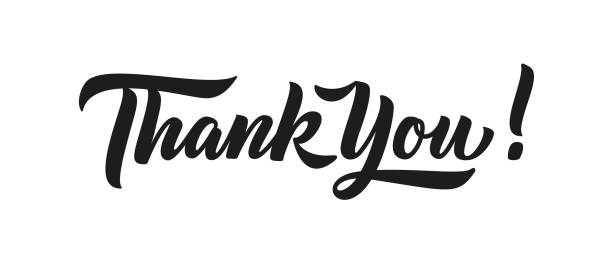